In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df=pd.read_csv('/content/gdrive/MyDrive/ECG/Matadata_ECG.csv')

In [ ]:
df

,Location,Labels
0,/ECG Dataset/ECG/Test/AF/0.png,1
1,/ECG Dataset/ECG/Train/SR/1.png,0
2,/ECG Dataset/ECG/Train/SR/2.png,0
3,/ECG Dataset/ECG/Train/AF/3.png,1
4,/ECG Dataset/ECG/Train/SR/4.png,0
...,...,...
3582,/ECG Dataset/ECG/Train/AF/3582.png,1
3583,/ECG Dataset/ECG/Train/SR/3583.png,0
3584,/ECG Dataset/ECG/Train/SR/3584.png,0
3585,/ECG Dataset/ECG/Test/AF/3585.png,1


In [ ]:
df.Labels.value_counts()

Labels
0    2000
1    1587
Name: count, dtype: int64

In [ ]:
import tensorflow as tf

# defining the path
ds_trainn= tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/ECG/Train')
ds_testt= tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/ECG/Test')

Found 2869 files belonging to 2 classes.
Found 718 files belonging to 2 classes.


In [ ]:
# define the batch size and print the image labels
#dataset_name = dataset
#class_names = dataset.class_names
#print(class_names)

import tensorflow_datasets as tfds

batch_size = 32

size= (224, 224)
ds_train=ds_trainn.map(lambda image, label:(tf.image.resize(image, size), label))
ds_test=ds_testt.map(lambda image, label:(tf.image.resize(image, size), label))

Number of classes: 2
Number of training samples: 90
Number of validation samples: 23


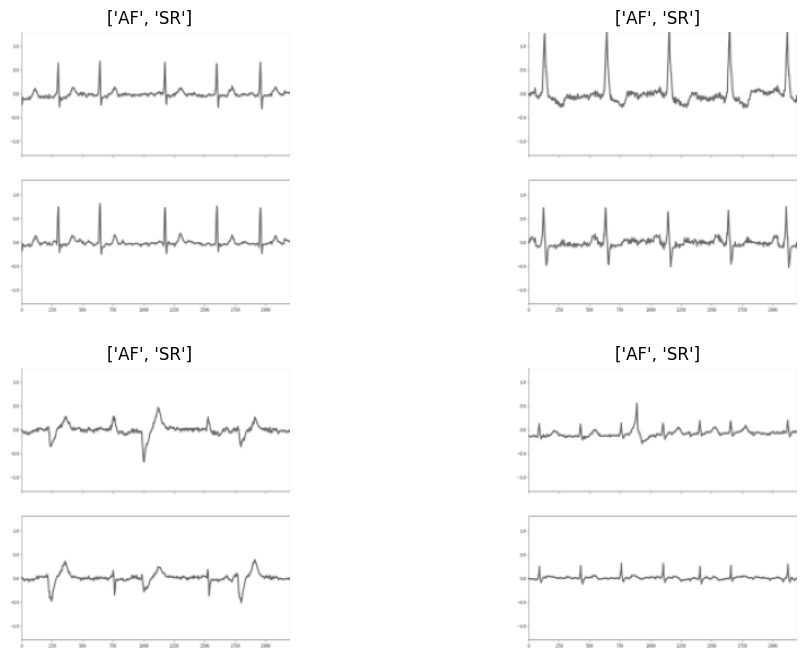

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get information about the dataset
num_classes = 2
num_train_samples = ds_trainn.cardinality().numpy()
num_test_samples = ds_testt.cardinality().numpy()
class_names=['AF', 'SR']

print("Number of classes:", num_classes)
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_test_samples)


plt.figure(figsize=(12, 8))
for images, labels in ds_trainn.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names)
        plt.axis("off")
plt.show()


# **1. Simple CNN**

In [ ]:
import tensorflow as tf

from keras import layers, models
from keras.callbacks import Callback


model = models.Sequential()

# Convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display the model summary
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Custom callback to store validation accuracies
class ValAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.val_acc.append(logs.get('val_accuracy'))

# Instantiate the callback
val_acc_history = ValAccHistory()

# Train the model
history = model.fit(ds_train, validation_data=ds_test, epochs=50)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(ds_test)
val_acc= val_acc*100
print("Validation Accuracy:", val_acc)

# Save validation accuracies in an array
#Simple_CNN = val_acc_history.val_acc
#print("Validation Accuracies:", Simple_CNN)
#np.save('simple_CNN.npy', Simple_CNN)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

AttributeError: 'ValAccHistory' object has no attribute 'val_acc'

# **2.VGG16**

In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.callbacks import Callback

# Load the VGG16 model pre-trained on ImageNet
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4, activation='softmax'))

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(ds_train, validation_data=ds_test, epochs=50)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(ds_test)
val_acc= val_acc*100
print("Validation Accuracy:", val_acc)

# Save validation accuracies in an array
VGG16 = val_acc_history.val_acc
print("Validation Accuracies:", VGG16)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21138500 (80.64 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.callbacks import Callback

# Load the VGG16 model pre-trained on ImageNet
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(4, activation='softmax'))

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Custom callback to store validation accuracies
class ValAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.val_acc.append(logs.get('val_accuracy'))

# Instantiate the callback
val_acc_history = ValAccHistory()

# Train the model with the custom callback
history = model.fit(ds_train, validation_data=ds_test, epochs=50, callbacks=[val_acc_history])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(ds_test)
val_acc= val_acc*100
print("Validation Accuracy:", val_acc)

# Save validation accuracies in an array
VGG16 = val_acc_history.val_acc
print("Validation Accuracies:", VGG16)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21138500 (80.64 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1

NameError: name 'np' is not defined

In [ ]:
import numpy as np
from google.colab import files
VGG16= [x * 100 for x in VGG16]
np.save('VGG16.npy', VGG16)
files.download('VGG16.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

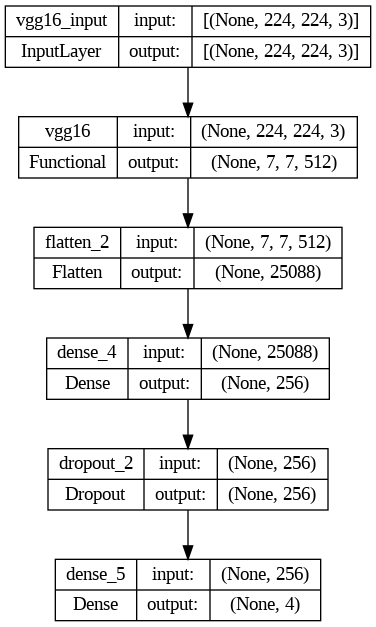

In [ ]:
from keras.utils import plot_model
# Draw the architecture diagram
plot_model(model, to_file='vgg16_model_architecture.png', show_shapes=True, show_layer_names=True)

# To display the image in Jupyter Notebook
from IPython.display import Image
Image(filename='vgg16_model_architecture.png')

# Applying **XAI** LIME and SHAP

In [ ]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.7 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=435281682984b6cf0da1af6878873769a8aedf0e9a241aae3fdc7f148f8b237f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
import numpy as np
import tensorflow as tf

# Define the prediction function
def predict_fn(images):
    return model.predict(images)

# Select a batch of data from the test set for explanation
for images, labels in ds_test.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 21138500 (80.64 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


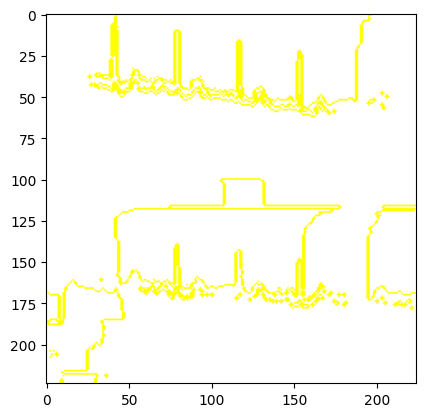

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


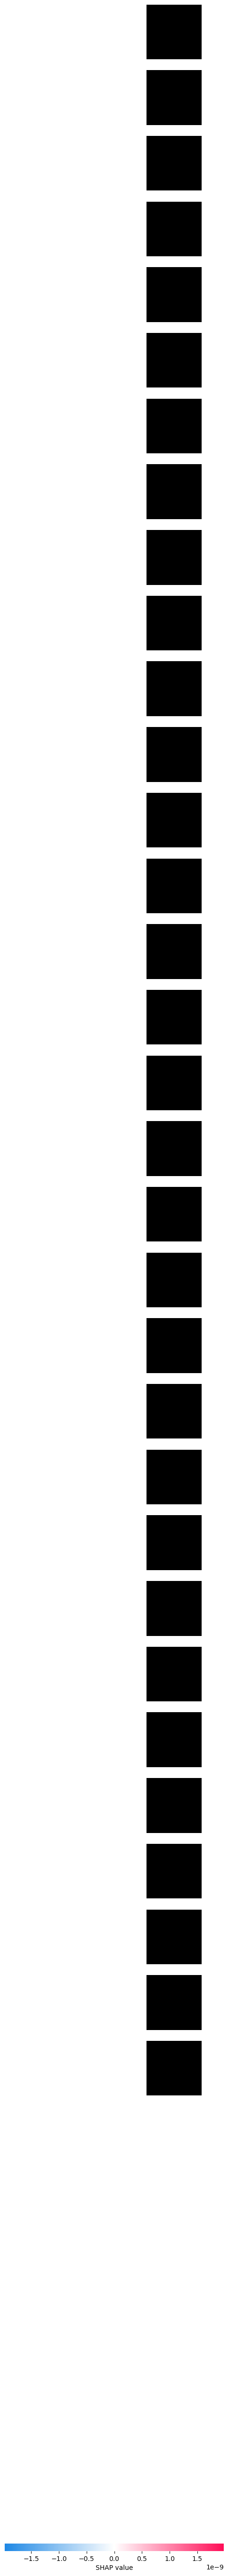

In [ ]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap
import numpy as np

# Get information about the dataset
num_classes = 2
class_names = ['AF', 'SR']


# Load the VGG16 model pre-trained on ImageNet
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(ds_train, validation_data=ds_test, epochs=50)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(ds_test)
print("Validation Accuracy:", val_acc)

# Define the prediction function
def predict_fn(images):
    return model.predict(images)

# Select a batch of data from the test set for explanation
for images, labels in ds_test.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()

# LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(sample_images[0].astype('double'), predict_fn, top_labels=2, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

# SHAP explanation
explainer = shap.GradientExplainer(model, sample_images)
shap_values = explainer.shap_values(sample_images)
shap.image_plot(shap_values, sample_images)


# **3.ResNet32**

In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.applications import ResNet50
from keras.callbacks import Callback

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model using the pre-trained ResNet50 as the base
model = models.Sequential()

# Add the ResNet50 base model
model.add(base_model)
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
# Custom callback to store validation accuracies
class ValAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.val_acc.append(logs.get('val_accuracy'))

# Instantiate the callback
val_acc_history = ValAccHistory()

# Train the model with the custom callback
history = model.fit(ds_train, validation_data=ds_test, epochs=50, callbacks=[val_acc_history])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(ds_test)
val_acc= val_acc*100
print("Validation Accuracy:", val_acc)

# Save validation accuracies in an array
ResNet32 = val_acc_history.val_acc
print("Validation Accuracies:", ResNet32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49278594 (187.98 MB)
Trainable params: 25690882 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch

In [ ]:
import numpy as np
from google.colab import files
np.save('ResNet32.npy', ResNet32)
ResNet32= [x * 100 for x in ResNet32]
np.save('ResNet32.npy', ResNet32)
files.download('ResNet32.npy')

In [ ]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
print(configuration)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.40.0"
}



# **ViT (Visual Transformer)**

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ViTForImageClassification
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_folder_path = '/content/gdrive/MyDrive/ECG/Train'
test_folder_path = '/content/gdrive/MyDrive/ECG/Test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class_names = ['SR', 'AF']

# Load datasets
train_dataset = datasets.ImageFolder(train_folder_path, transform=transform)
train_dataset.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

test_dataset = datasets.ImageFolder(test_folder_path, transform=transform)
test_dataset.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the ViT model and image processor
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Freeze the pre-trained model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the classification head for the number of classes in the dataset
model.classifier = nn.Linear(model.config.hidden_size, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialize array to store test accuracies
test_accuracies = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)  # Save the test accuracy

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the test accuracies to a file
np.save('ViT.npy', test_accuracies*100)

Epoch 1/50, Train Loss: 0.6546, Train Accuracy: 0.6413, Test Accuracy: 0.6476
Epoch 2/50, Train Loss: 0.5924, Train Accuracy: 0.7330, Test Accuracy: 0.7173
Epoch 3/50, Train Loss: 0.5524, Train Accuracy: 0.7689, Test Accuracy: 0.7744
Epoch 4/50, Train Loss: 0.5219, Train Accuracy: 0.7860, Test Accuracy: 0.7855
Epoch 5/50, Train Loss: 0.4992, Train Accuracy: 0.7957, Test Accuracy: 0.7911
Epoch 6/50, Train Loss: 0.4811, Train Accuracy: 0.8006, Test Accuracy: 0.7925
Epoch 7/50, Train Loss: 0.4675, Train Accuracy: 0.7999, Test Accuracy: 0.7967
Epoch 8/50, Train Loss: 0.4561, Train Accuracy: 0.8048, Test Accuracy: 0.8022
Epoch 9/50, Train Loss: 0.4446, Train Accuracy: 0.8076, Test Accuracy: 0.8050
Epoch 10/50, Train Loss: 0.4368, Train Accuracy: 0.8125, Test Accuracy: 0.7981
Epoch 11/50, Train Loss: 0.4292, Train Accuracy: 0.8149, Test Accuracy: 0.8036
Epoch 12/50, Train Loss: 0.4238, Train Accuracy: 0.8104, Test Accuracy: 0.8106
Epoch 13/50, Train Loss: 0.4161, Train Accuracy: 0.8229, Test

In [ ]:
files.download('ViT.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***ARRAY FORM OF DATA***

In [ ]:
import numpy as np
# Load the data from Google Drive
y = np.load('/content/gdrive/MyDrive/ECG/arr2D_AF&SR_label.npy')
X = np.load('/content/gdrive/MyDrive/ECG/items_AF&SR.npy')

In [ ]:
X.shape

(3587, 1000, 3)

In [ ]:
X

array([[[ 0.135, -0.125, -0.08 ],
        [ 0.135, -0.125, -0.08 ],
        [ 0.135, -0.125, -0.08 ],
        ...,
        [-0.125, -0.066, -0.07 ],
        [-0.126, -0.063, -0.07 ],
        [-0.124, -0.06 , -0.07 ]],

       [[-0.13 , -0.045, -0.03 ],
        [-0.13 , -0.045, -0.03 ],
        [-0.13 , -0.045, -0.03 ],
        ...,
        [ 0.003,  0.027, -0.02 ],
        [ 0.005,  0.025, -0.018],
        [ 0.005,  0.024, -0.015]],

       [[-0.47 , -0.43 , -0.72 ],
        [-0.47 , -0.43 , -0.72 ],
        [-0.47 , -0.43 , -0.72 ],
        ...,
        [-0.064,  0.111,  0.471],
        [-0.075,  0.11 ,  0.467],
        [-0.081,  0.11 ,  0.458]],

       ...,

       [[ 0.025, -0.065,  0.06 ],
        [ 0.025, -0.065,  0.06 ],
        [ 0.025, -0.065,  0.06 ],
        ...,
        [-0.012, -0.035, -0.018],
        [-0.018, -0.006, -0.016],
        [-0.02 ,  0.013, -0.021]],

       [[ 0.15 ,  0.15 ,  0.02 ],
        [ 0.15 ,  0.15 ,  0.02 ],
        [ 0.15 ,  0.15 ,  0.02 ],
        .

In [ ]:
import numpy as np
arr = X
# Indices to remove from the third dimension
indices_to_remove = [2]  # 1st, 3rd, 7th positions

# Remove the specified positions from the third dimension
arr = np.delete(arr, indices_to_remove, axis=2)
print(arr.shape)

(3587, 1000, 2)


In [ ]:
#X = np.concatenate((s, a))
len(X)

3587

In [ ]:
#y = np.concatenate((sl, al))
len(y)

3587

In [ ]:
print(y.shape)
print(y)

(3587, 1)
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
# Preprocessing
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

print(X_scaled)

[[[ 0.80705828 -0.4588596  -0.25228113]
  [ 0.80705828 -0.4588596  -0.25228113]
  [ 0.80705828 -0.4588596  -0.25228113]
  ...
  [-0.71186622 -0.24757386 -0.22215566]
  [-0.71770824 -0.23683052 -0.22215566]
  [-0.7060242  -0.22608717 -0.22215566]]

 [[-0.7410763  -0.17237046 -0.10165378]
  [-0.7410763  -0.17237046 -0.10165378]
  [-0.7410763  -0.17237046 -0.10165378]
  ...
  [ 0.035912    0.08546976 -0.07152831]
  [ 0.04759603  0.07830753 -0.06550321]
  [ 0.04759603  0.07472642 -0.05646557]]

 [[-2.72736219 -1.55109943 -2.18031125]
  [-2.72736219 -1.55109943 -2.18031125]
  [-2.72736219 -1.55109943 -2.18031125]
  ...
  [-0.35550316  0.38628336  1.4076323 ]
  [-0.41976535  0.38270224  1.39558212]
  [-0.45481746  0.38270224  1.36846919]]

 ...

 [[ 0.16443638 -0.24399274  0.16947546]
  [ 0.16443638 -0.24399274  0.16947546]
  [ 0.16443638 -0.24399274  0.16947546]
  ...
  [-0.05171826 -0.13655932 -0.06550321]
  [-0.08677037 -0.03270701 -0.05947812]
  [-0.0984544   0.03533416 -0.07454085]]

 [

# **Splitting the dataset** [taking every 5th index set as testing set]

In [ ]:
import numpy as np

# Assuming X and Y are your arrays
X_s = X_scaled
Y_s = y
# Generate indices for splitting
indices = np.arange(len(Y_s))

# Split the indices into train and test sets
test_indices = indices[::5]  # Every fifth index
train_indices = np.setdiff1d(indices, test_indices)

# Split X and Y using the generated indices
X_tr = X_s[train_indices]
Y_tr = Y_s[train_indices]

X_ts = X_s[test_indices]
Y_ts = Y_s[test_indices]

# Check the shapes
print("X_train shape:", X_tr.shape)
print("Y_train shape:", Y_tr.shape)
print("X_test shape:", X_ts.shape)
print("Y_test shape:", Y_ts.shape)

X_train shape: (2869, 1000, 3)
Y_train shape: (2869, 1)
X_test shape: (718, 1000, 3)
Y_test shape: (718, 1)


## **CNN-LSTM **

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

# Define model parameters
num_classes = 2
input_shape = (1000, 3)  # assuming 1000 time steps and 12 leads

# Reshape the data to fit the CNN input shape
X_train_cnn = X_tr.reshape((-1, input_shape[0], input_shape[1]))  # reshape without channel dimension
X_test_cnn = X_ts.reshape((-1, input_shape[0], input_shape[1]))

# Define CNN-LSTM model architecture
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(X_train_cnn, Y_tr, epochs=80, batch_size=64, validation_split=0.1)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_ts, Y_ts)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 998, 64)           640       
                                                                 
 max_pooling1d (MaxPooling1  (None, 499, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 248, 128)          0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 248, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)               

# **CNN-Bi-LSTM **

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Bidirectional

# Define model parameters
num_classes = 2
input_shape = (1000, 3)  # assuming 1000 time steps and 3 features

# Reshape the data to fit the CNN input shape
X_train_cnn = X_tr.reshape((-1, input_shape[0], input_shape[1]))  # reshape without channel dimension
X_test_cnn = X_ts.reshape((-1, input_shape[0], input_shape[1]))

# Define CNN-Bi-LSTM model architecture
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(X_train_cnn, Y_tr, epochs=100, batch_size=64, validation_split=0.1)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_cnn, Y_ts)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 998, 64)           640       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 499, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 497, 128)          24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 248, 128)          0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 248, 128)          98816     
 onal)                                                           
                                                      

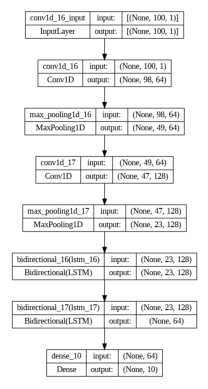

In [41]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Define your model architecture
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Generate plot using plot_model with custom styling
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=96)

# Load the generated image using matplotlib
image = plt.imread('model_plot.png')
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()



In [ ]:
from keras.utils import plot_model
# Draw the architecture diagram
plot_model(model, to_file='vgg16_model_architecture.png', show_shapes=True, show_layer_names=True)

# To display the image in Jupyter Notebook
from IPython.display import Image
Image(filename='vgg16_model_architecture.png')

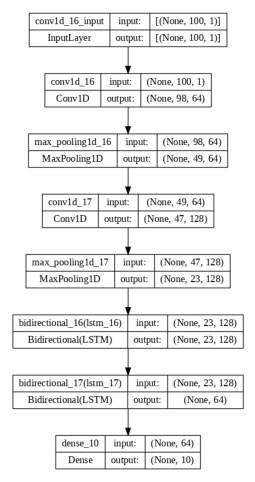

In [56]:
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import Image

# Adjust plot_model settings for style
plot_model(model, to_file='vgg16_model_architecture.png', show_shapes=True, show_layer_names=True, dpi=100)

# Load and display the image with Matplotlib
img = plt.imread('vgg16_model_architecture.png')
plt.figure(figsize=(6, 6))  # Adjust figure size to make it square and clear
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()



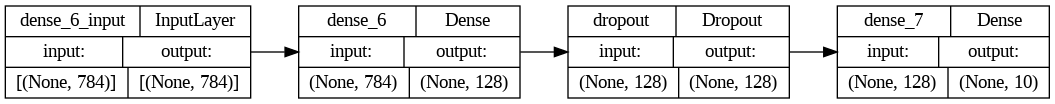

In [38]:
import tensorflow as tf
from keras.utils import plot_model
from IPython.display import Image, display

# Assuming `model` is your Keras model
# Example model creation
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(784,), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Generate the plot with detailed options
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, rankdir='LR')

# Display the image
img = Image('model_architecture.png')
display(img)


In [ ]:
LSTM=[44.52, 45.55, 45.56, 46.97, 46.45, 46.92, 47.57, 47.45, 47.45, 47.92, 47.97, 48.12, 48.32, 48.37, 49.11, 49.11, 49.11, 49.52, 49.52, 49.52, 48.12, 48.32,
      48.37, 49.11, 49.11, 49.11, 49.52, 49.52, 49.52, 50.25, 51.12, 52.12, 53.12, 54.12, 55.12, 55.12, 55.12, 56.00, 56.00, 56.57, 56.27,  56.27, 56.13, 56.55,
      56.27, 55.99,  56.69, 56.96, 55.99, 56.13, 56.13, 56.27, 55.15, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13,
      56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 56.13, 57.13, 57.13, 58.00, 57.13, 58.25, 58.25, 58.13, 58.97, 58.97, 59.13, 59.13,
      59.13, 59.92, 59.93, 59.58, 66.55, 64.46, 67.60, 56.45, 68.99, 65.96, 66.55, 67.40]

CNN_LSTM=[59.93, 59.58, 66.55, 64.46, 67.60, 56.45, 68.99, 75.96, 66.55, 83.62, 68.64, 60.63, 55.40, 58.54, 59.93, 69.34, 54.01, 72.13, 71.43, 74.56, 73.87, 72.82,
          76.31, 77.35, 79.09, 86.06, 84.32, 82.93, 83.97, 88.50, 85.02, 91.64, 90.94, 88.85, 92.68, 92.33, 91.99, 92.33, 91.99, 85.37, 89.20, 90.59, 91.64, 91.64,
          92.68, 90.59, 92.68, 91.29, 91.99, 92.33, 93.38, 91.64, 91.64, 92.33, 90.94, 91.64, 91.64, 93.38, 91.99, 92.33, 91.99, 90.94, 93.03, 90.24, 92.33, 92.33,
          91.99, 90.94, 91.29, 91.64, 90.24, 91.64, 91.64, 91.29, 91.99, 91.99, 93.03, 93.38, 91.64, 92.33, 91.99, 90.94, 93.03, 90.24, 92.33, 92.33, 91.99, 90.94,
          91.29, 91.64, 90.24, 91.64, 91.64, 91.29, 91.99, 91.99, 93.03, 93.38, 91.64, 91.64]

CNN_Bi_LSTM=[60.63, 64.81, 66.55, 67.60, 68.99, 70.73, 73.52, 72.82, 71.78, 77.70, 84.32, 86.41, 85.37, 76.66, 89.20, 70.73, 73.52, 72.82, 71.78, 77.70, 84.32, 86.41,
              85.37, 76.66, 89.20, 87.11, 87.11, 90.59, 63.41, 73.17, 81.53, 84.32, 87.11, 82.93, 80.84, 82.93, 85.71, 83.62, 82.58, 87.46, 87.11, 82.93, 80.84, 82.93,
              85.71, 83.62, 87.11, 82.93, 80.84, 82.93, 85.71, 83.62, 82.58, 87.46, 87.11, 82.93, 80.84, 82.93, 85.71, 83.62, 82.58, 87.46, 87.11, 90.94, 89.90, 93.73,
              92.33, 93.38, 94.77, 94.43, 90.24, 93.38, 93.38, 88.8, 92.68, 90.94, 89.90, 93.73, 92.33, 93.38, 94.77, 94.43, 90.24, 93.38, 93.38, 88.8, 92.68, 92.68,
              93.03, 93.38, 91.64, 93.38, 92.33, 93.38, 94.43, 93.03, 94.77, 94.43, 95.47, 93.73]
